# TiledImageIterDataPipe Demo - 25k x 25k preprocessing

This notebook exercises PyTorch's tiling DataPipe on 25,000 x 25,000 inputs while staying memory-aware. The examples reuse a single synthetic image, avoid Python loops, and only inspect a handful of tiles per scenario.


## Goals

- Build a realistic 25k image without blowing memory
- Validate tile shapes/order, boundary handling, overlap, and caching
- Show integration points (multiple images, grayscale, DataLoader, reconstruction)


In [1]:
# Import PyTorch from the local source checkout before any torch imports
import os
import sys
import time
from collections import deque
from typing import Iterable

repo_root = os.path.abspath(os.path.join(os.getcwd(), "../pytorch"))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import torch
import torch.utils.data.datapipes as dp
from torch.utils.data.datapipes.iter.tiling import (
    TiledImageIterDataPipe as TiledImage,
    TileInfo,
    TileOrder,
    BoundaryMode,
)

import matplotlib.pyplot as plt

# Configuration for the large-image scenarios
IMAGE_SIZE = 25_000
CHANNELS = 3
DEFAULT_TILE = 1_000
DTYPE = torch.float16  # keeps memory reasonable while supporting padding values
DEVICE = torch.device("cpu")

torch.manual_seed(0)
print(f"Running on {DEVICE} with dtype={DTYPE} and IMAGE_SIZE={IMAGE_SIZE}")

def tensor_gb(t: torch.Tensor) -> float:
    return t.element_size() * t.numel() / (1024 ** 3)

def make_large_image(
    image_size: int = IMAGE_SIZE,
    channels: int = CHANNELS,
    dtype: torch.dtype = DTYPE,
    device: torch.device = DEVICE,
) -> torch.Tensor:
    # Generate a deterministic gradient pattern without Python loops.
    base = torch.empty((1, image_size, image_size), device=device, dtype=torch.float32)
    row = torch.arange(image_size, device=device, dtype=torch.float32).view(1, image_size, 1)
    col = torch.arange(image_size, device=device, dtype=torch.float32).view(1, 1, image_size)
    torch.add(row, col, out=base)
    base.remainder_(512)
    base.div_(512)
    base = base.to(dtype)
    if channels == 1:
        return base
    return base.expand(channels, -1, -1).clone()

def make_tile_dp(image: torch.Tensor, **kwargs) -> TiledImage:
    return dp.iter.IterableWrapper([image]).tile(**kwargs)

def peek_tiles(tiled_dp: Iterable[TileInfo], limit: int = 5) -> None:
    start = time.time()
    count = 0
    for tile in tiled_dp:
        print(
            f"Tile {count}: row={tile.row}, col={tile.col}, pos=({tile.y_start},{tile.x_start}), shape={tuple(tile.tile.shape)}"
        )
        count += 1
        if count >= limit:
            break
    if count == 0:
        print("No tiles emitted.")
    else:
        print(f"Peeked {count} tile(s) in {time.time() - start:.2f}s")

def count_tiles(tiled_dp: Iterable[TileInfo]) -> int:
    return sum(1 for _ in tiled_dp)


Running on cpu with dtype=torch.float16 and IMAGE_SIZE=25000


## Build a 25k gradient image

Vectorized generation keeps creation fast; float16 keeps memory around 3.7 GB for a 3-channel tensor. Reuse this tensor across the rest of the notebook to avoid extra allocations.


In [2]:
base_image = make_large_image()
print(f"Base image shape: {tuple(base_image.shape)}, dtype={base_image.dtype}, ~{tensor_gb(base_image):.2f} GB")


Base image shape: (3, 25000, 25000), dtype=torch.float16, ~3.49 GB


## 1. Basic tiling and TileInfo

Split the 25k image into 1000x1000 tiles, inspect the first few, and confirm the metadata emitted in `TileInfo`.


In [3]:
peek_tiles(make_tile_dp(base_image, tile_size=DEFAULT_TILE, stride=DEFAULT_TILE), limit=5)

grid = IMAGE_SIZE // DEFAULT_TILE
tile_count = count_tiles(make_tile_dp(base_image, tile_size=DEFAULT_TILE, stride=DEFAULT_TILE))
print(f"Total tiles emitted: {tile_count} (expected {grid * grid} for {grid}x{grid} grid)")

sample_tile = next(iter(make_tile_dp(base_image, tile_size=DEFAULT_TILE, stride=DEFAULT_TILE)))
print("TileInfo fields:")
print(f"  tile shape: {tuple(sample_tile.tile.shape)}")
print(f"  row,col: ({sample_tile.row}, {sample_tile.col})")
print(f"  starts: y={sample_tile.y_start}, x={sample_tile.x_start}")
print(f"  source_index: {sample_tile.source_index}")


Tile 0: row=0, col=0, pos=(0,0), shape=(3, 1000, 1000)
Tile 1: row=0, col=1, pos=(0,1000), shape=(3, 1000, 1000)
Tile 2: row=0, col=2, pos=(0,2000), shape=(3, 1000, 1000)
Tile 3: row=0, col=3, pos=(0,3000), shape=(3, 1000, 1000)
Tile 4: row=0, col=4, pos=(0,4000), shape=(3, 1000, 1000)
Peeked 5 tile(s) in 0.10s
Total tiles emitted: 625 (expected 625 for 25x25 grid)
TileInfo fields:
  tile shape: (3, 1000, 1000)
  row,col: (0, 0)
  starts: y=0, x=0
  source_index: 0


## 2. Tile ordering

Use larger 5000x5000 tiles (5x5 grid) to make the ordering easy to read.


In [4]:
order_tile = 5_000
for order in (TileOrder.ROW_MAJOR, TileOrder.COLUMN_MAJOR, TileOrder.HILBERT):
    positions = [
        (t.row, t.col)
        for t in TiledImage(
            dp.iter.IterableWrapper([base_image]),
            tile_size=order_tile,
            tile_order=order,
        )
    ]
    print(f"{order.name}: {positions}")


ROW_MAJOR: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
COLUMN_MAJOR: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (0, 4), (1, 4), (2, 4), (3, 4), (4, 4)]
HILBERT: [(0, 0), (1, 0), (1, 1), (0, 1), (0, 2), (0, 3), (1, 3), (1, 2), (2, 2), (2, 3), (3, 3), (3, 2), (3, 1), (2, 1), (2, 0), (3, 0), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (3, 4), (2, 4), (1, 4), (0, 4)]


## 3. Boundary modes (non-divisible edges)

Tiles of 1200 pixels do not divide 25k evenly. Compare `SKIP`, `CROP`, and `PAD` without materializing all tiles at once.


In [5]:
edge_tile = 1_200
print(f"{IMAGE_SIZE} with tile_size={edge_tile}: full tiles per dim = {IMAGE_SIZE // edge_tile}, remainder={IMAGE_SIZE % edge_tile}")

def summarize_boundary(mode: BoundaryMode) -> None:
    dp_edge = TiledImage(
        dp.iter.IterableWrapper([base_image]),
        tile_size=edge_tile,
        boundary_mode=mode,
        pad_value=-1.0,
    )
    first = []
    last = deque(maxlen=3)
    count = 0
    last_tile = None
    for tile in dp_edge:
        if count < 3:
            first.append(((tile.row, tile.col), tuple(tile.tile.shape)))
        last.append(((tile.row, tile.col), tuple(tile.tile.shape)))
        last_tile = tile
        count += 1
    print(f"{mode.name}: {count} tile(s)")
    print(f"  first tiles: {first}")
    print(f"  last tiles: {list(last)}")
    if mode == BoundaryMode.PAD and last_tile is not None:
        pad_count = (last_tile.tile == -1.0).sum().item()
        print(f"  padding pixels in last tile: {pad_count}")

summarize_boundary(BoundaryMode.SKIP)
summarize_boundary(BoundaryMode.CROP)
summarize_boundary(BoundaryMode.PAD)


25000 with tile_size=1200: full tiles per dim = 20, remainder=1000
SKIP: 400 tile(s)
  first tiles: [((0, 0), (3, 1200, 1200)), ((0, 1), (3, 1200, 1200)), ((0, 2), (3, 1200, 1200))]
  last tiles: [((19, 17), (3, 1200, 1200)), ((19, 18), (3, 1200, 1200)), ((19, 19), (3, 1200, 1200))]
CROP: 441 tile(s)
  first tiles: [((0, 0), (3, 1200, 1200)), ((0, 1), (3, 1200, 1200)), ((0, 2), (3, 1200, 1200))]
  last tiles: [((20, 18), (3, 1000, 1200)), ((20, 19), (3, 1000, 1200)), ((20, 20), (3, 1000, 1000))]
PAD: 441 tile(s)
  first tiles: [((0, 0), (3, 1200, 1200)), ((0, 1), (3, 1200, 1200)), ((0, 2), (3, 1200, 1200))]
  last tiles: [((20, 18), (3, 1200, 1200)), ((20, 19), (3, 1200, 1200)), ((20, 20), (3, 1200, 1200))]
  padding pixels in last tile: 1320000


## 4. Overlapping and non-square tiles

Show how overlap increases coverage and how rectangular tiles are reported.


In [6]:
overlap_stride = DEFAULT_TILE // 2
tiles_no_overlap = count_tiles(make_tile_dp(base_image, tile_size=DEFAULT_TILE, stride=DEFAULT_TILE))
tiles_overlap = count_tiles(make_tile_dp(base_image, tile_size=DEFAULT_TILE, stride=overlap_stride))
print(f"Non-overlap: {tiles_no_overlap} tiles (stride={DEFAULT_TILE})")
print(f"50% overlap: {tiles_overlap} tiles (stride={overlap_stride}, x{tiles_overlap / tiles_no_overlap:.2f} more)")

print("Rectangular tiles (600x400):")
peek_tiles(make_tile_dp(base_image, tile_size=(600, 400), stride=(600, 400)), limit=4)


Non-overlap: 625 tiles (stride=1000)
50% overlap: 2401 tiles (stride=500, x3.84 more)
Rectangular tiles (600x400):
Tile 0: row=0, col=0, pos=(0,0), shape=(3, 600, 400)
Tile 1: row=0, col=1, pos=(0,400), shape=(3, 600, 400)
Tile 2: row=0, col=2, pos=(0,800), shape=(3, 600, 400)
Tile 3: row=0, col=3, pos=(0,1200), shape=(3, 600, 400)
Peeked 4 tile(s) in 0.04s


## 5. Multiple images and grayscale inputs

Stream multiple large images one at a time to avoid holding them all in memory, and confirm 2D grayscale tensors work as well.


In [7]:
images_dp = dp.iter.IterableWrapper(range(2)).map(lambda _: make_large_image())
tiled_multi = images_dp.tile(tile_size=DEFAULT_TILE)
peek_tiles(tiled_multi, limit=6)

gray_image = make_large_image(channels=1)
gray_dp = make_tile_dp(gray_image, tile_size=DEFAULT_TILE)
gray_first = next(iter(gray_dp))
gray_count = count_tiles(make_tile_dp(gray_image, tile_size=DEFAULT_TILE))
print(f"Grayscale first tile shape: {tuple(gray_first.tile.shape)}")
print(f"Total grayscale tiles: {gray_count}")
del gray_image


/Users/zernach/code/pytorch/torch/utils/data/datapipes/iter/callable.py:83: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  _check_unpickable_fn(fn)


Tile 0: row=0, col=0, pos=(0,0), shape=(3, 1000, 1000)
Tile 1: row=0, col=1, pos=(0,1000), shape=(3, 1000, 1000)
Tile 2: row=0, col=2, pos=(0,2000), shape=(3, 1000, 1000)
Tile 3: row=0, col=3, pos=(0,3000), shape=(3, 1000, 1000)
Tile 4: row=0, col=4, pos=(0,4000), shape=(3, 1000, 1000)
Tile 5: row=0, col=5, pos=(0,5000), shape=(3, 1000, 1000)
Peeked 6 tile(s) in 0.22s
Grayscale first tile shape: (1, 1000, 1000)
Total grayscale tiles: 625


## 6. LRU cache for repeated access

Cache tiles when revisiting the same regions repeatedly.


In [8]:
cache_dp = TiledImage(
    dp.iter.IterableWrapper([base_image]),
    tile_size=DEFAULT_TILE,
    cache_size=12,
)
for idx, _ in enumerate(cache_dp):
    if idx >= 10:
        break
print(f"Cache size after partial iteration: {len(cache_dp._cache._cache)}")
cache_dp.reset()
print(f"Cache size after reset(): {len(cache_dp._cache._cache)}")


Cache size after partial iteration: 11
Cache size after reset(): 0


## 7. Reconstruct to validate tiling

Stitch tiles back together to ensure no data is lost.


Tiled and reconstructed 25000x25000: True


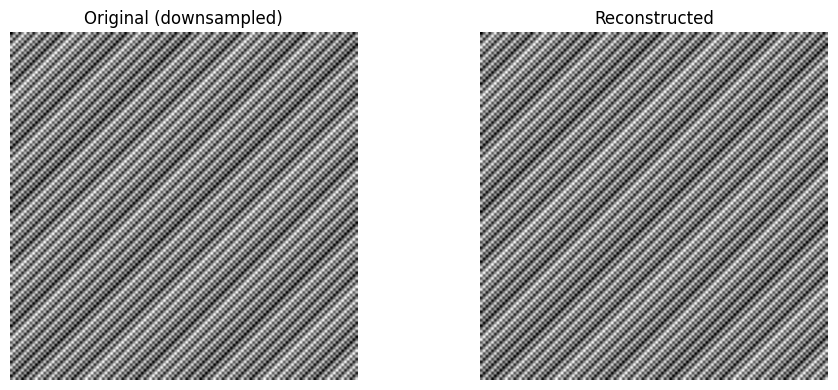

In [9]:
reconstructed = torch.zeros_like(base_image)
for tile in make_tile_dp(base_image, tile_size=DEFAULT_TILE):
    y, x = tile.y_start, tile.x_start
    h, w = tile.tile.shape[1:]
    reconstructed[:, y:y+h, x:x+w] = tile.tile
print(f"Tiled and reconstructed {IMAGE_SIZE}x{IMAGE_SIZE}: {torch.equal(base_image, reconstructed)}")

# Visual sanity check (downsampled for display)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(base_image[:, ::200, ::200].float().permute(1, 2, 0).numpy())
axes[0].set_title("Original (downsampled)")
axes[0].axis("off")
axes[1].imshow(reconstructed[:, ::200, ::200].float().permute(1, 2, 0).numpy())
axes[1].set_title("Reconstructed")
axes[1].axis("off")
plt.tight_layout()
plt.show()

del reconstructed


## 8. DataLoader integration

Batch tiles from multiple 25k images. Images are generated lazily to keep peak memory in check.


In [10]:
from torch.utils.data import DataLoader

images_dp = dp.iter.IterableWrapper(range(2)).map(lambda _: make_large_image())
loader_tiles = images_dp.tile(tile_size=1_500)

def collate_tiles(batch):
    tiles = torch.stack([item.tile for item in batch])
    rows = [item.row for item in batch]
    cols = [item.col for item in batch]
    sources = [item.source_index for item in batch]
    return tiles, rows, cols, sources

loader = DataLoader(loader_tiles, batch_size=4, collate_fn=collate_tiles, num_workers=0)
for batch_idx, (tiles, rows, cols, sources) in enumerate(loader):
    print(f"Batch {batch_idx}: tiles={tuple(tiles.shape)}, rows={rows}, cols={cols}, sources={sources}")
    if batch_idx >= 2:
        break


Batch 0: tiles=(4, 3, 1500, 1500), rows=[0, 0, 0, 0], cols=[0, 1, 2, 3], sources=[0, 0, 0, 0]
Batch 1: tiles=(4, 3, 1500, 1500), rows=[0, 0, 0, 0], cols=[4, 5, 6, 7], sources=[0, 0, 0, 0]
Batch 2: tiles=(4, 3, 1500, 1500), rows=[0, 0, 0, 0], cols=[8, 9, 10, 11], sources=[0, 0, 0, 0]
